In [1]:
########### Preparation ##############
# import packages
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Import des données
On crée un dataframe Egos qui contient non seulement les informations sur les egos mais aussi leur réseau personnel (egoNet) avec les données des alters.

In [2]:
Egos = pd.read_csv('../data/ego_data.csv', sep = ",")
order_age_cat = ['18-25', '26-30', '31-35','36-40', '41-50', '51-60', '60+']
Egos['ego.age.cat'] = pd.Categorical(Egos['ego.age.cat'], 
                                     categories=order_age_cat, ordered=True)
order_edu_cat = ['Primary', 'Secondary', 'University']
Egos['ego.edu'] = pd.Categorical(Egos['ego.edu'], 
                                     categories=order_edu_cat, ordered=True)
Egos['ego.employed'] = Egos['ego.empl.bin']=="Yes"
Alters = pd.read_csv('../data/alter_attributes.csv', sep = ",")
AltersEdglist = pd.read_table('../data/alter_ties.csv', sep = ",")

def CreatingEgoNet(ego_ID):
    egoNet = nx.from_pandas_edgelist(AltersEdglist[AltersEdglist["ego_ID"]==ego_ID], 'from','to', create_using=nx.Graph())
    nodeData = Alters[Alters["ego_ID"]==ego_ID].set_index('alter_ID').to_dict('index').items()
    egoNet.add_nodes_from(nodeData)
    return egoNet
Egos["egoNet"] = Egos["ego_ID"].apply(CreatingEgoNet)
Egos.set_index("ego_ID", inplace=True)

# adding years since arrival variable
reference_year = 2018 # year of Vacca's publication
Egos["ego.years_since_arr"] = reference_year - Egos["ego.arr"]

# Définir les limites des catégories
bins = [-1, 4, 9, 14, 19, 24, float('inf')]  # Les limites des catégories sont inclusives à gauche et exclusives à droite

# Définir les labels des catégories
labels = ['0-4 ans', '5-9 ans', '10-14 ans', '15-19 ans', '20-24 ans' , '25+ ans']

# Créer une nouvelle colonne avec les catégories
Egos['ego.years_since_arr.cat'] = pd.cut(Egos['ego.years_since_arr'], bins=bins, labels=labels)

Egos.sample(5)

,ego.sex,ego.age,ego.arr,ego.edu,ego.inc,empl,ego.empl.bin,ego.age.cat,ego.employed,egoNet,ego.years_since_arr,ego.years_since_arr.cat
ego_ID,,,,,,,,,,,,
99,Male,55.0,2008.0,Primary,220.0,3,Yes,51-60,True,"(9901, 9902, 9903, 9904, 9905, 9906, 9907, 990...",10.0,10-14 ans
144,Male,53.0,2000.0,Primary,350.0,4,Yes,51-60,True,"(14401, 14402, 14403, 14404, 14405, 14406, 144...",18.0,15-19 ans
74,Male,29.0,2010.0,Primary,400.0,3,Yes,26-30,True,"(7401, 7402, 7403, 7406, 7407, 7408, 7409, 741...",8.0,5-9 ans
124,Male,54.0,2004.0,University,850.0,4,Yes,51-60,True,"(12401, 12402, 12403, 12404, 12405, 12406, 124...",14.0,10-14 ans
78,Male,39.0,2010.0,Secondary,250.0,2,No,36-40,False,"(7801, 7802, 7803, 7804, 7805, 7806, 7807, 780...",8.0,5-9 ans


On peut facilement visualiser le réseau de n'importe quel ego de cette façon

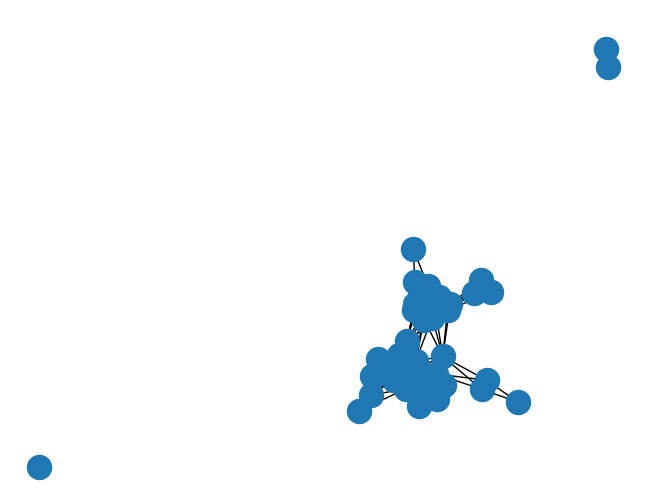

In [3]:
nx.draw(Egos.loc[149,"egoNet"])

## Stats desc sur les egos

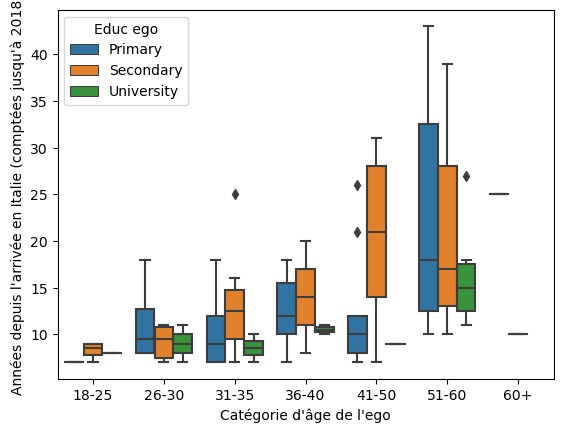

In [4]:
sns.boxplot(data=Egos, x='ego.age.cat', y="ego.years_since_arr", hue="ego.edu", hue_order=order_edu_cat)
plt.xlabel("Catégorie d'âge de l'ego")
plt.ylabel("Années depuis l'arrivée en Italie (comptées jusqu'à 2018)")
plt.legend(title='Educ ego')

# Quelques statistiques structurelles sur les réseaux ego

In [5]:
import networkx as nx
import numpy as np

def calculate_network_metrics(df, egoNet_name):
    """
    Calculate various network metrics for each network in the specified column of a DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the network data.
        egoNet_name (str): The name of the column containing the network data.

    Returns:
        None. Modifies the DataFrame in place by adding columns with calculated metrics.
    """
    # presence of the network
    df[egoNet_name + ".is_empty"] = df[egoNet_name].apply(nx.is_empty)

    # ---- Mean local structures
    # Function to calculate the number of isolates
    nb_isolates = lambda net: len(list(nx.isolates(net))) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".nb_isolates"] = df[egoNet_name].apply(nb_isolates)

    # Triads
    # Function to calculate transitivity
    transitivity = lambda net: nx.transitivity(net) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".transitivity"] = df[egoNet_name].apply(transitivity)

    # Function to calculate average clustering
    avg_clustering = lambda net: nx.average_clustering(net) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".average_clustering"] = df[egoNet_name].apply(avg_clustering)

    # ---- Global structures : cohesion
    # Function to calculate density
    density = lambda net: nx.density(net) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".density"] = df[egoNet_name].apply(density)

    # ---- Global structures : connectivity -> not for undirected networks

    # ---- Global structures : centrality
    # Function to calculate mean degree centrality
    mean_degree_centrality = lambda net: np.mean(list(nx.degree_centrality(net).values())) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".mean_degree_centrality"] = df[egoNet_name].apply(mean_degree_centrality)

    # Function to calculate mean eigenvector centrality
    # mean_eigenvector_centrality = lambda net: np.mean(list(nx.eigenvector_centrality(net).values()))
    # df[egoNet_name + ".mean_eigenvector_centrality"] = df[egoNet_name].apply(mean_eigenvector_centrality)

    # Function to calculate mean betweenness centrality
    mean_betweenness_centrality = lambda net: np.mean(list(nx.betweenness_centrality(net).values())) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".mean_betweenness_centrality"] = df[egoNet_name].apply(mean_betweenness_centrality)

    # Function to calculate mean closeness centrality
    mean_closeness_centrality = lambda net: np.mean(list(nx.closeness_centrality(net).values())) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".mean_closeness_centrality"] = df[egoNet_name].apply(mean_closeness_centrality)


# Usage:
calculate_network_metrics(Egos, "egoNet")


In [6]:
def compute_attributes(df, egoNet_name):
    """
    Calculate various network aggregated attributes for each network.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the network data.
        egoNet_name (str): The name of the column containing the network data.

    Returns:
        None. Modifies the DataFrame in place by adding columns with calculated metrics.
    """

    # number nodes
    nb_nodes = lambda net: nx.number_of_nodes(net) if not nx.is_empty(net) else 0
    df[egoNet_name + ".nb_nodes"] = df[egoNet_name].apply(nb_nodes) 

    # ratio of men in the network
    ratio_men = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.sex").values()))=="Male") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_men"] = df[egoNet_name].apply(ratio_men)

    # ratio of women in the network
    ratio_women = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.sex").values()))=="Female") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_women"] = df[egoNet_name].apply(ratio_women)

    # ratio of close family
    ratio_close_family = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.rel").values()))=="Close family") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_close_family"] = df[egoNet_name].apply(ratio_close_family)

    # ratio of other family
    ratio_other_family = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.rel").values()))=="Other family") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_other_family"] = df[egoNet_name].apply(ratio_other_family)
    
    # ratio of friends
    ratio_friends = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.rel").values()))=="Friends") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_friends"] = df[egoNet_name].apply(ratio_friends)

    # ratio of acquaintances
    ratio_acquaintances = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.rel").values()))=="Acquaintances") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_acquaintances"] = df[egoNet_name].apply(ratio_acquaintances)

    # mean age of the network
    mean_age = lambda net: np.mean(list(nx.get_node_attributes(net,'alter.age').values())) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".mean_age"] = df[egoNet_name].apply(mean_age)

    # ratio of men in the networks


# Usage:
compute_attributes(Egos, "egoNet")

# Découpe du Ego Net en sous réseau selon l'origine de l'Alter

## Exemple sur  l'Ego 28 et définitions de fonctions

In [7]:
egoNet28  = Egos.loc[28,"egoNet"]

In [8]:
import networkx as nx

def filter_graph_by_attribute(graph, attribute_name, desired_category, keep_true=True):
    """
    Filter a NetworkX graph based on a categorical attribute and retain node attributes.
    
    Parameters:
        graph (nx.Graph): The original NetworkX graph.
        attribute_name (str): The name of the categorical attribute to filter on.
        desired_category (str): The desired category value.
        keep_true (bool): If True, keep nodes where the attribute matches the desired category.
                          If False, keep nodes where the attribute does not match the desired category.
    
    Returns:
        nx.Graph: The filtered graph.
    """
    filtered_graph = nx.Graph()
    
    try:
        # Add nodes from the original graph based on the value of the categorical attribute
        for n, data in graph.nodes(data=True):
            if (keep_true and data.get(attribute_name) == desired_category) or (not keep_true and data.get(attribute_name) != desired_category):
                filtered_graph.add_node(n, **data)
        
        # Add edges from the original graph involving the filtered nodes
        for u, v, data in graph.edges(data=True):
            if u in filtered_graph and v in filtered_graph:  # Ensure both nodes are in the filtered graph
                filtered_graph.add_edge(u, v, **data)
        
    except Exception as e:
        print("An error occurred while filtering the graph:", e)
    
    return filtered_graph

# Example usage:
# Assuming G is your original graph
# filtered_G = filter_graph_by_attribute(G, 'category_attribute', 'desired_category_value', keep_true=True)

Réseau personnel de l'ego 28 au Sri Lanka

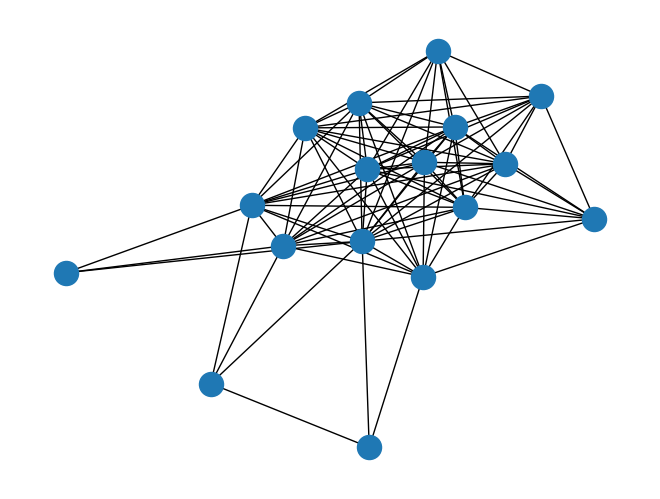

In [9]:
filter_resSL_natSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=True),
                                  'alter.res', "Sri Lanka", keep_true=True)
nx.draw(filter_resSL_natSL(egoNet28))

Réseau personnel de l'ego 28 de Srilankais habitant en Italie

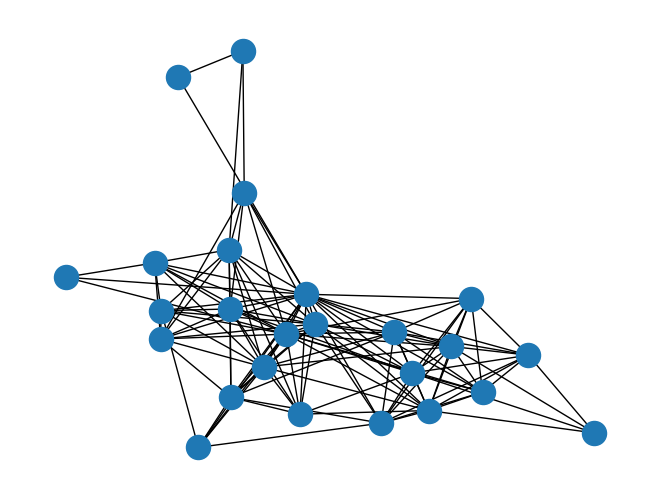

In [10]:
filter_resIT_natSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=True),
                                  'alter.res', "Italy", keep_true=True)
nx.draw(filter_resIT_natSL(egoNet28))

Réseau personnel de l'ego 28 en Italie non srilankais

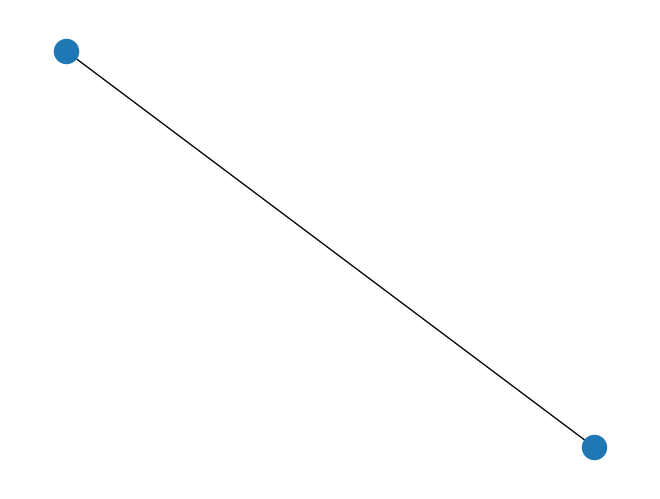

In [11]:
filter_resIT_natNonSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=False),
                                  'alter.res', "Italy", keep_true=True)
nx.draw(filter_resIT_natNonSL(egoNet28))

Réseau personnel de l'ego 28 de nationalité italienne

In [12]:
filter_natIT = lambda net: filter_graph_by_attribute(net, 
                                'alter.nat', "Italy", keep_true=True)
nx.is_empty(filter_natIT(egoNet28))

True

## Sous réseaux du réseau Ego selon la nationalité et la résidence

In [13]:
Egos['resSL_natSL_egoNet'] = Egos['egoNet'].apply(filter_resSL_natSL)
Egos['resIT_natSL_egoNet'] = Egos['egoNet'].apply(filter_resIT_natSL)
Egos['resIT_natNonSL_egoNet'] = Egos['egoNet'].apply(filter_resIT_natNonSL)
Egos['natIT_egoNet'] = Egos['egoNet'].apply(filter_natIT)

In [14]:
calculate_network_metrics(Egos, 'resSL_natSL_egoNet')
calculate_network_metrics(Egos, 'resIT_natSL_egoNet')
calculate_network_metrics(Egos, 'resIT_natNonSL_egoNet')
calculate_network_metrics(Egos, 'natIT_egoNet')

### Présence d'un réseau Sri Lankais au Sri Lanka

In [15]:
Egos['resSL_natSL_egoNet.is_empty'].value_counts()

False    101
True       1
Name: resSL_natSL_egoNet.is_empty, dtype: int64

### Présence d'un réseau Sri Lankais en Italie

In [16]:
Egos['resIT_natSL_egoNet.is_empty'].value_counts()

False    102
Name: resIT_natSL_egoNet.is_empty, dtype: int64

### Présence d'un réseau en Italie, non srilankais

In [17]:
Egos['resIT_natNonSL_egoNet.is_empty'].value_counts()

False    77
True     25
Name: resIT_natNonSL_egoNet.is_empty, dtype: int64

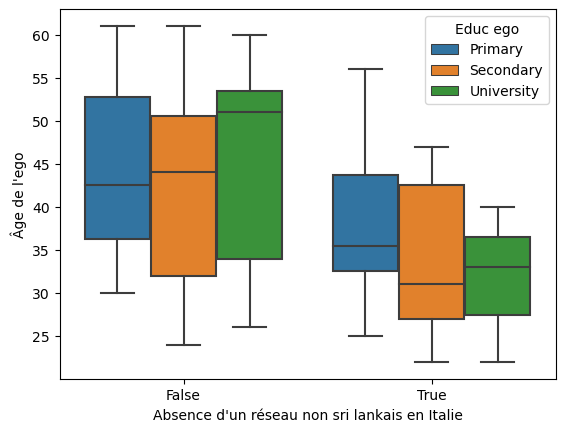

In [18]:
sns.boxplot(data=Egos, x='resIT_natNonSL_egoNet.is_empty', y="ego.age", hue="ego.edu", hue_order=order_edu_cat)
plt.xlabel("Absence d'un réseau non sri lankais en Italie")
plt.ylabel("Âge de l'ego")
plt.legend(title='Educ ego')

On peut voir que les personnes avec un réseau en Italien qui n'est pas composé uniquement de Sri Lankais sont tendanciellement plus jeunes.

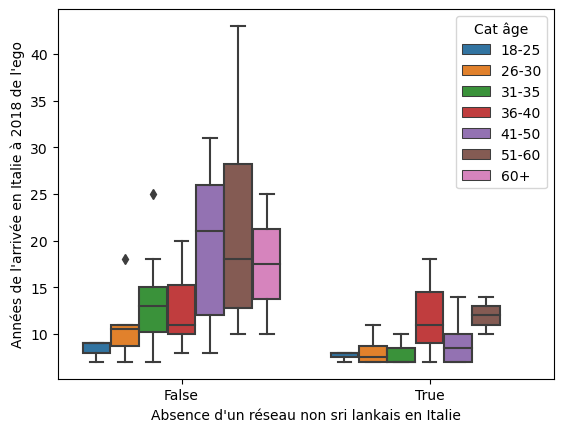

In [19]:
sns.boxplot(data=Egos, x='resIT_natNonSL_egoNet.is_empty', y="ego.years_since_arr", hue="ego.age.cat", hue_order=order_age_cat)
plt.xlabel("Absence d'un réseau non sri lankais en Italie")
plt.ylabel("Années de l'arrivée en Italie à 2018 de l'ego")
plt.legend(title='Cat âge')

Ils sont aussi tendanciellement arrivé récemment en Italie.

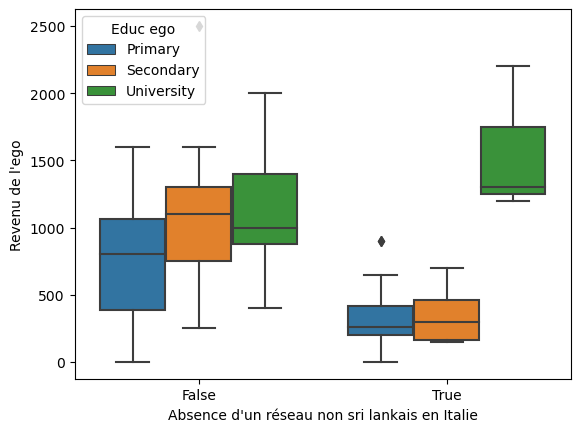

In [20]:
sns.boxplot(data=Egos, x='resIT_natNonSL_egoNet.is_empty', y="ego.inc", hue="ego.edu", hue_order=order_edu_cat)
plt.xlabel("Absence d'un réseau non sri lankais en Italie")
plt.ylabel("Revenu de l'ego")
plt.legend(title='Educ ego')

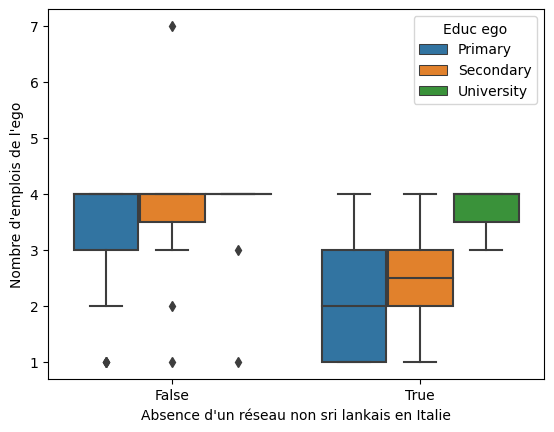

In [21]:
sns.boxplot(data=Egos, x='resIT_natNonSL_egoNet.is_empty', y="empl", hue="ego.edu", hue_order=order_edu_cat)
plt.xlabel("Absence d'un réseau non sri lankais en Italie")
plt.ylabel("Nombre d'emplois de l'ego")
plt.legend(title='Educ ego')

### Présence d'un réseau composé d'italiens

In [22]:
Egos['natIT_egoNet.is_empty'].value_counts()

False    69
True     33
Name: natIT_egoNet.is_empty, dtype: int64

# Comparaison réseau Sri Lankais au Sri Lanka et Sri Lankais en Italie

## En fonction de leurs structures

## En fonction de leurs caractéristiques

In [23]:
compute_attributes(Egos, 'resIT_natSL_egoNet')
compute_attributes(Egos, 'resIT_natNonSL_egoNet')

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définir les variables à comparer
attributes_to_compare = ['ratio_men', 'ratio_close_family', 'ratio_other_family', 'ratio_friends','mean_age']

# Définir les réseaux à comparer
networks_to_compare = ['resIT_natSL_egoNet', 'resIT_natNonSL_egoNet']

dict_network_names_to_labels = {'resIT_natSL_egoNet':"SL en Italie",
                                'resIT_natNonSL_egoNet':"Non SL en Italie"}

# Covariables pour comparaison
covariates_to_compare = ['ego.age.cat','ego.edu','ego.years_since_arr.cat']

# Filtrer le DataFrame pour inclure uniquement les colonnes correspondant aux attributs à comparer et aux réseaux à comparer
filtered_df = Egos[[f"{network}.{attribute}" for network in networks_to_compare for attribute in attributes_to_compare]]

# Renommer les colonnes en fonction du type de réseau
filtered_df.columns = pd.MultiIndex.from_tuples([(attribute.split('.')[1], attribute.split('.')[0]) for attribute in filtered_df.columns], names=['Attribute', 'Network'])

# Réaliser une opération de pivot où le préfixe devient un type de variable
pivot_df = filtered_df.stack(level='Network').reset_index()

pivot_df = pivot_df.join(Egos[covariates_to_compare], on = "ego_ID",how = "left",validate="many_to_one")

pivot_df.head()


,ego_ID,Network,mean_age,ratio_close_family,ratio_friends,ratio_men,ratio_other_family,ego.age.cat,ego.edu,ego.years_since_arr.cat
0,28,resIT_natNonSL_egoNet,46.000000,0.000000,0.500000,0.000000,0.0,60+,Secondary,10-14 ans
1,28,resIT_natSL_egoNet,43.160000,0.000000,0.720000,1.000000,0.0,60+,Secondary,10-14 ans
2,29,resIT_natSL_egoNet,41.933333,0.033333,0.833333,0.966667,0.0,36-40,Primary,15-19 ans
3,33,resIT_natNonSL_egoNet,34.307692,0.000000,0.153846,0.692308,0.0,26-30,Primary,5-9 ans
4,33,resIT_natSL_egoNet,39.600000,0.000000,0.800000,0.800000,0.0,26-30,Primary,5-9 ans


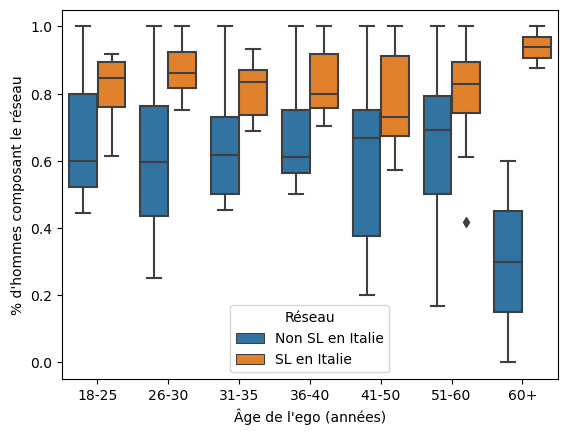

In [25]:
sns.boxplot(data=pivot_df, x='ego.age.cat', y="ratio_men", hue='Network')
plt.xlabel("Âge de l'ego (années)")
plt.ylabel("% d'hommes composant le réseau")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Réseau', handles=handles, labels=[dict_network_names_to_labels[name] for name in labels])

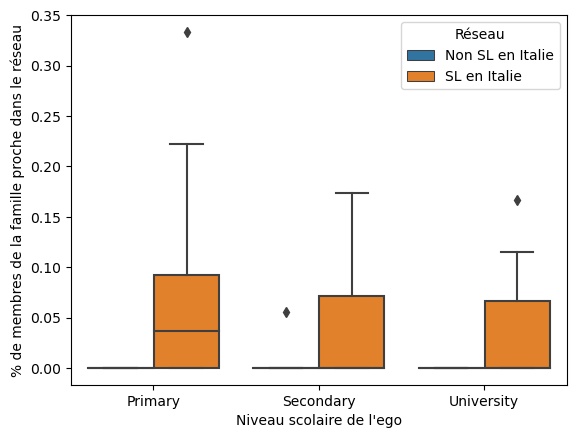

In [26]:
sns.boxplot(data=pivot_df, x='ego.edu', y="ratio_close_family", hue='Network')
plt.xlabel("Niveau scolaire de l'ego")
plt.ylabel("% de membres de la famille proche dans le réseau")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Réseau', handles=handles, labels=[dict_network_names_to_labels[name] for name in labels])

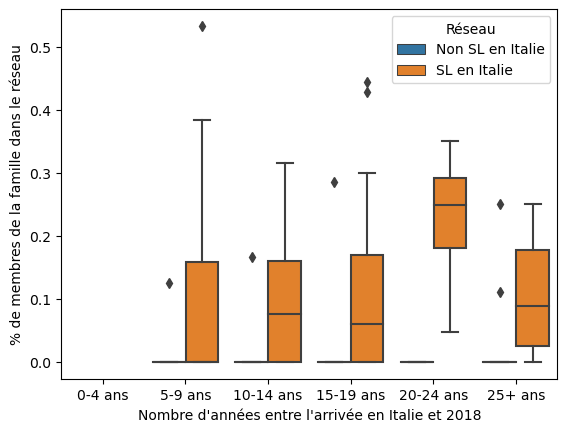

In [27]:
# Créer un box plot avec Seaborn
pivot_df["ratio_family"] = pivot_df['ratio_other_family']  + pivot_df['ratio_close_family']
sns.boxplot(data=pivot_df, x='ego.years_since_arr.cat', y="ratio_other_family", hue='Network')
plt.xlabel("Nombre d'années entre l'arrivée en Italie et 2018")
plt.ylabel("% de membres de la famille dans le réseau")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Réseau', handles=handles, labels=[dict_network_names_to_labels[name] for name in labels])


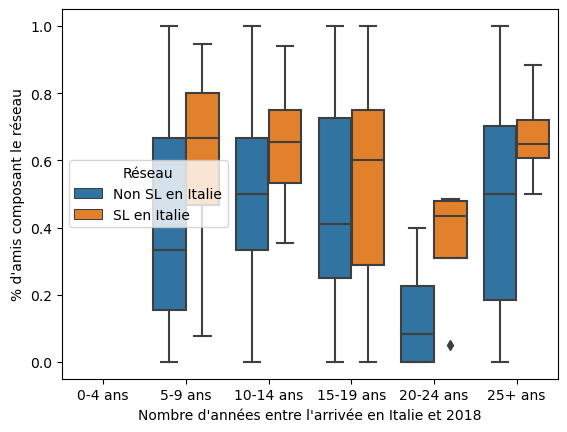

In [28]:
sns.boxplot(data=pivot_df, x='ego.years_since_arr.cat', y="ratio_friends", hue='Network')
plt.xlabel("Nombre d'années entre l'arrivée en Italie et 2018")
plt.ylabel("% d'amis composant le réseau")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Réseau', handles=handles, labels=[dict_network_names_to_labels[name] for name in labels])


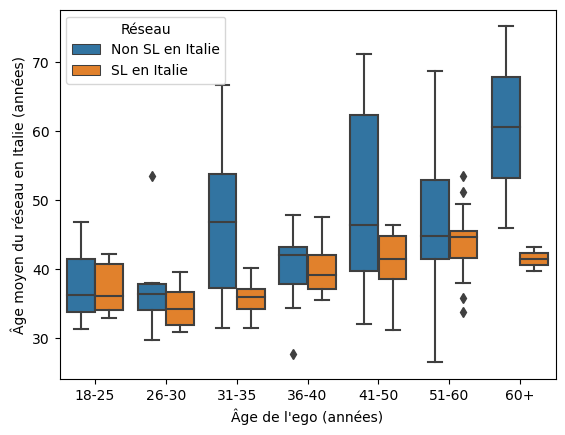

In [29]:
# Créer un box plot avec Seaborn
sns.boxplot(data=pivot_df, x='ego.age.cat', y="mean_age", hue='Network')
plt.xlabel("Âge de l'ego (années)")
plt.ylabel("Âge moyen du réseau en Italie (années)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Réseau', handles=handles, labels=[dict_network_names_to_labels[name] for name in labels])


## Liens entre les réseaux sri lankais et non sri lankais en Italie